# Condensing the configuration space fine grained

In [1]:
import pickle
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from ad_config_search.config_space_control import ConfigSpace

%load_ext autoreload
%autoreload 2

## Get fine grained policy

In [2]:
with open("df_configs_5sectors.pl", 'rb') as f:
    df_configs_5sectors = pickle.load(f)

In [23]:
df_configs_5sectors

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,metric
0,training_0000-S23-P0_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,30.547550,T_mota
1,training_0000-S23-P1_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,39.197930,T_mota
2,training_0000-S23-P2_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,37.049861,T_mota
3,training_0000-S23-P3_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,28.266494,T_mota
4,training_0000-S23-P4_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,29.371688,T_mota
...,...,...,...,...,...,...,...,...,...,...
1704955,training_0003-S1-P0_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-9.959350,T_mota
1704956,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-3.034682,T_mota
1704957,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-10.264901,T_mota
1704958,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-27.734375,T_mota


In [4]:
df_configs_5sectors = df_configs_5sectors[df_configs_5sectors["D-seq-pol"] != "infinite"]
df_configs_5sectors["D-conf"] = df_configs_5sectors["D-conf"].astype(float)
df_configs_5sectors["T-min-iou"] = df_configs_5sectors["T-min-iou"].astype(float)
df_configs_5sectors["T-max-age"] = df_configs_5sectors["T-max-age"].astype(int)
df_configs_5sectors["T-every-nth-det"] = df_configs_5sectors["T-every-nth-det"].astype(int)
df_configs_5sectors["score"] = df_configs_5sectors["score"].astype(float)

In [5]:
config_space_5sectors = ConfigSpace(df_configs_5sectors,
                                    scenario_column="run",
                                    metric_column="metric",
                                    score_column="score",
                                    config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"])

In [6]:
oracle_5sectors_policy = config_space_5sectors.oracle_per_scenario_policy("T_mota")
oracle_5sectors_policy_scores = config_space_5sectors.get_scores_of_policy(oracle_5sectors_policy, "T_mota")

100%|██████████| 740/740 [01:22<00:00,  8.98it/s]


## Per-scenario grained analysis

### Load policy and count occurence of configurations

In [7]:
oracle_per_scenario_policy_str = {k: json.dumps(v) for k,v in oracle_5sectors_policy.items()}

In [8]:
oracle_configs, oracle_config_counts = np.unique(list(oracle_per_scenario_policy_str.values()), return_counts=True)

### Distribution is long/heavy tailed

([<matplotlib.axis.XTick at 0x7f57b0d7a208>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

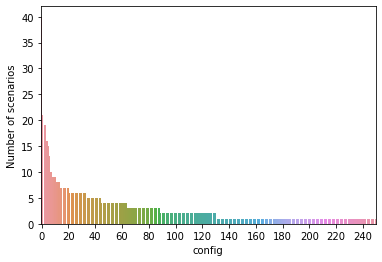

In [9]:
# plt.title("Number of scenarios with the same optimal config")
plt.ylabel("Number of scenarios")
plt.xlabel("config")
sns.barplot(x=np.arange(len(oracle_config_counts)), y=sorted(oracle_config_counts, reverse=True))
plt.xticks(ticks=np.arange(0,260,20))

In [10]:
# subexponential
np.std(oracle_config_counts)/np.mean(oracle_config_counts)

1.2925730421889967

In [50]:
# configs in descending order of popularity
np.transpose([oracle_configs[np.argsort(oracle_config_counts)[::-1]], sorted(oracle_config_counts, reverse=True)])

array([['{"D-model": "efficientdet-d7x", "D-conf": 0.5, "D-seq-pol": "eager", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 1}',
        '40'],
       ['{"D-model": "efficientdet-d7x", "D-conf": 0.3, "D-seq-pol": "tail-aware", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 1}',
        '21'],
       ['{"D-model": "efficientdet-d7x", "D-conf": 0.5, "D-seq-pol": "wait", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 1}',
        '19'],
       ['{"D-model": "efficientdet-d7x", "D-conf": 0.3, "D-seq-pol": "eager", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 1}',
        '19'],
       ['{"D-model": "efficientdet-d7x", "D-conf": 0.5, "D-seq-pol": "tail-aware", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 1}',
        '16'],
       ['{"D-model": "efficientdet-d7x", "D-conf": 0.3, "D-seq-pol": "wait", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 1}',
        '15'],
       ['{"D-model": "efficientdet-d4", "D-conf": 0.3, "D-seq-pol": "eager", "T-min-io

### Cumulative coverage fairly poor

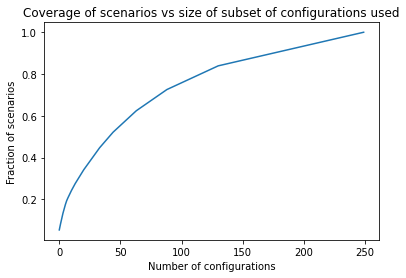

In [11]:
plt.title("Coverage of scenarios vs size of subset of configurations used")
plt.xlabel("Number of configurations")
plt.ylabel("Fraction of scenarios")
plt.plot(np.cumsum(sorted(oracle_config_counts, reverse=True))/np.sum(oracle_config_counts))

## Check if the top k 

In [13]:
from ad_config_search.utils import condense_v1

### Small sanity check

In [17]:
json.dumps(oracle_5sectors_policy["training_0001-S3-P4_5"])

'{"D-model": "efficientdet-d6", "D-conf": 0.5, "D-seq-pol": "wait", "T-min-iou": 0.3, "T-max-age": 7, "T-every-nth-det": 1}'

In [83]:
oracle_k_1_dict, oracle_k_1_perf_drop = condense_v1(df_configs_5sectors, oracle_5sectors_policy, k=1)
oracle_k_1_configs, oracle_k_1_counts = np.unique(list(oracle_k_1_dict.values()), return_counts=True)

100%|██████████| 740/740 [01:08<00:00, 10.79it/s]


In [85]:
len(oracle_k_1_dict.keys())

740

In [88]:
for k in oracle_per_scenario_policy_str.keys():
    assert oracle_k_1_perf_drop[k] == 0 or np.isnan(oracle_k_1_perf_drop[k])

### Testing higher k values

In [90]:
oracle_k_10_dict, oracle_k_10_perf_drop = condense_v1(df_configs_5sectors, oracle_5sectors_policy, k=10)
oracle_k_10_configs, oracle_k_10_counts = np.unique(list(oracle_k_10_dict.values()), return_counts=True)

100%|██████████| 740/740 [00:50<00:00, 14.66it/s]


In [91]:
oracle_k_20_dict, oracle_k_20_perf_drop = condense_v1(df_configs_5sectors, oracle_5sectors_policy, k=20)
oracle_k_20_configs, oracle_k_20_counts = np.unique(list(oracle_k_20_dict.values()), return_counts=True)

100%|██████████| 740/740 [00:36<00:00, 20.50it/s]


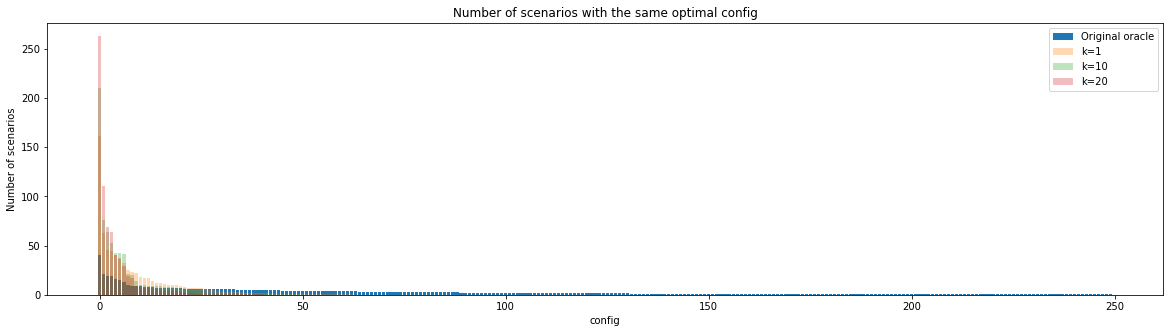

In [92]:
plt.figure(figsize=(20,5))
plt.title("Number of scenarios with the same optimal config")
plt.ylabel("Number of scenarios")
plt.xlabel("config")
plt.bar(x=np.arange(len(oracle_config_counts)), height=sorted(oracle_config_counts, reverse=True), label="Original oracle")
plt.bar(x=np.arange(len(oracle_k_1_counts)), height=sorted(oracle_k_1_counts, reverse=True), alpha=0.3, label="k=1")
plt.bar(x=np.arange(len(oracle_k_10_counts)), height=sorted(oracle_k_10_counts, reverse=True), alpha=0.3, label="k=10")
plt.bar(x=np.arange(len(oracle_k_20_counts)), height=sorted(oracle_k_20_counts, reverse=True), alpha=0.3, label="k=20")
plt.legend()

In [93]:
[
    np.std(oracle_config_counts)/np.mean(oracle_config_counts),
    np.std(oracle_k_1_counts)/np.mean(oracle_k_1_counts),
    np.std(oracle_k_10_counts)/np.mean(oracle_k_10_counts),
    np.std(oracle_k_20_counts)/np.mean(oracle_k_20_counts),
]

[1.2925730421889967,
 1.9557252395374753,
 2.2022466780475596,
 2.4762620278127163]

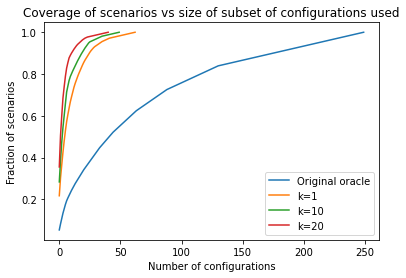

In [94]:
plt.title("Coverage of scenarios vs size of subset of configurations used")
plt.xlabel("Number of configurations")
plt.ylabel("Fraction of scenarios")
plt.plot(np.cumsum(sorted(oracle_config_counts, reverse=True))/np.sum(oracle_config_counts), label="Original oracle")
plt.plot(np.cumsum(sorted(oracle_k_1_counts, reverse=True))/np.sum(oracle_k_1_counts), label="k=1")
plt.plot(np.cumsum(sorted(oracle_k_10_counts, reverse=True))/np.sum(oracle_k_10_counts), label="k=10")
plt.plot(np.cumsum(sorted(oracle_k_20_counts, reverse=True))/np.sum(oracle_k_20_counts), label="k=20")
plt.legend()

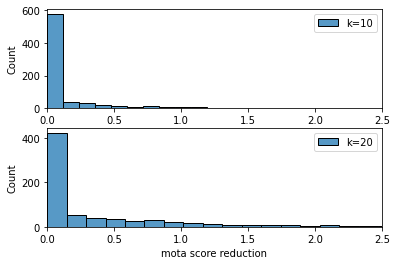

In [95]:
plt.figure()
plt.subplot(2,1,1)
plt.xlim([0,2.5])
sns.histplot(oracle_k_10_perf_drop.values(), bins=50, label="k=10")
plt.legend()
plt.subplot(2,1,2)
plt.xlim([0,2.5])
sns.histplot(oracle_k_20_perf_drop.values(), bins=50, label="k=20")
plt.xlabel("mota score reduction")
plt.legend()

In [97]:
np.nanmean(list(oracle_k_10_perf_drop.values())), np.nanmean(list(oracle_k_20_perf_drop.values()))

(0.13132769202173022, 0.44970617423138776)

## Extracting top 10 and top 20 configs

In [102]:
with open("oracle_k_10_policy.pl", 'wb') as f:
    pickle.dump({k: json.loads(v) for k,v in oracle_k_10_dict.items()}, f)

In [114]:
from ad_config_search.utils import condense_moment_policy_scores

ImportError: cannot import name 'condense_moment_policy_scores'

In [109]:
oracle_k_10_score_lists = {}
for k, v in tqdm(oracle_k_10_dict.items()):
    d = json.loads(v)
    d["run"] = k
    rows = get_rows(fine_grained_4s_scores, d)
    assert len(rows) == 1, len(rows)
    score = rows.iloc[0]["score"]
    scenario_name = "-".join(k.split("-")[:-1])
    if scenario_name not in oracle_k_10_score_lists:
        oracle_k_10_score_lists[scenario_name] = [score]
    else:
        oracle_k_10_score_lists[scenario_name].append(score)

        
oracle_k_10_score_lists = {k: np.mean(v) for k, v in oracle_k_10_score_lists.items()}

100%|██████████| 735/735 [04:58<00:00,  2.46it/s]


In [112]:
len(oracle_k_10_score_lists.keys())

148

In [111]:
with open("oracle_k_10_4s_grained_scores.pq", 'wb') as f:
    pickle.dump(oracle_k_10_score_lists, f)

In [101]:
oracle_k_20_configs

array(['{"D-model": "efficientdet-d1", "D-conf": 0.5, "D-seq-pol": "tail-aware", "T-model": "sort", "T-min-iou": 0.1, "T-max-age": 1, "T-every-nth-det": 1}',
       '{"D-model": "efficientdet-d1", "D-conf": 0.5, "D-seq-pol": "wait", "T-model": "sort", "T-min-iou": 0.1, "T-max-age": 1, "T-every-nth-det": 3}',
       '{"D-model": "efficientdet-d2", "D-conf": 0.5, "D-seq-pol": "eager", "T-model": "sort", "T-min-iou": 0.1, "T-max-age": 7, "T-every-nth-det": 3}',
       '{"D-model": "efficientdet-d2", "D-conf": 0.5, "D-seq-pol": "wait", "T-model": "sort", "T-min-iou": 0.2, "T-max-age": 1, "T-every-nth-det": 1}',
       '{"D-model": "efficientdet-d3", "D-conf": 0.3, "D-seq-pol": "eager", "T-model": "sort", "T-min-iou": 0.1, "T-max-age": 3, "T-every-nth-det": 1}',
       '{"D-model": "efficientdet-d3", "D-conf": 0.3, "D-seq-pol": "wait", "T-model": "sort", "T-min-iou": 0.3, "T-max-age": 3, "T-every-nth-det": 5}',
       '{"D-model": "efficientdet-d3", "D-conf": 0.5, "D-seq-pol": "tail-aware",